In [1]:
%pylab inline
figsize(14,8)

Populating the interactive namespace from numpy and matplotlib



========================================================
Gaussian process regression (GPR) on Mauna Loa CO2 data.
========================================================

This example is based on Section 5.4.3 of "Gaussian Processes for Machine
Learning" [RW2006]. It illustrates an example of complex kernel engineering and
hyperparameter optimization using gradient ascent on the
log-marginal-likelihood. The data consists of the monthly average atmospheric
CO2 concentrations (in parts per million by volume (ppmv)) collected at the
Mauna Loa Observatory in Hawaii, between 1958 and 1997. The objective is to
model the CO2 concentration as a function of the time t.

The kernel is composed of several terms that are responsible for explaining
different properties of the signal:

- a long term, smooth rising trend is to be explained by an RBF kernel. The
  RBF kernel with a large length-scale enforces this component to be smooth;
  it is not enforced that the trend is rising which leaves this choice to the
  GP. The specific length-scale and the amplitude are free hyperparameters.

- a seasonal component, which is to be explained by the periodic
  ExpSineSquared kernel with a fixed periodicity of 1 year. The length-scale
  of this periodic component, controlling its smoothness, is a free parameter.
  In order to allow decaying away from exact periodicity, the product with an
  RBF kernel is taken. The length-scale of this RBF component controls the
  decay time and is a further free parameter.

- smaller, medium term irregularities are to be explained by a
  RationalQuadratic kernel component, whose length-scale and alpha parameter,
  which determines the diffuseness of the length-scales, are to be determined.
  According to [RW2006], these irregularities can better be explained by
  a RationalQuadratic than an RBF kernel component, probably because it can
  accommodate several length-scales.

- a "noise" term, consisting of an RBF kernel contribution, which shall
  explain the correlated noise components such as local weather phenomena,
  and a WhiteKernel contribution for the white noise. The relative amplitudes
  and the RBF's length scale are further free parameters.

Maximizing the log-marginal-likelihood after subtracting the target's mean
yields the following kernel with an LML of -83.214::

   34.4**2 * RBF(length_scale=41.8)
   + 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44,
                                                      periodicity=1)
   + 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957)
   + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)

Thus, most of the target signal (34.4ppm) is explained by a long-term rising
trend (length-scale 41.8 years). The periodic component has an amplitude of
3.27ppm, a decay time of 180 years and a length-scale of 1.44. The long decay
time indicates that we have a locally very close to periodic seasonal
component. The correlated noise has an amplitude of 0.197ppm with a length
scale of 0.138 years and a white-noise contribution of 0.197ppm. Thus, the
overall noise level is very small, indicating that the data can be very well
explained by the model. The figure shows also that the model makes very
confident predictions until around 2015.


Automatically created module for IPython interactive environment


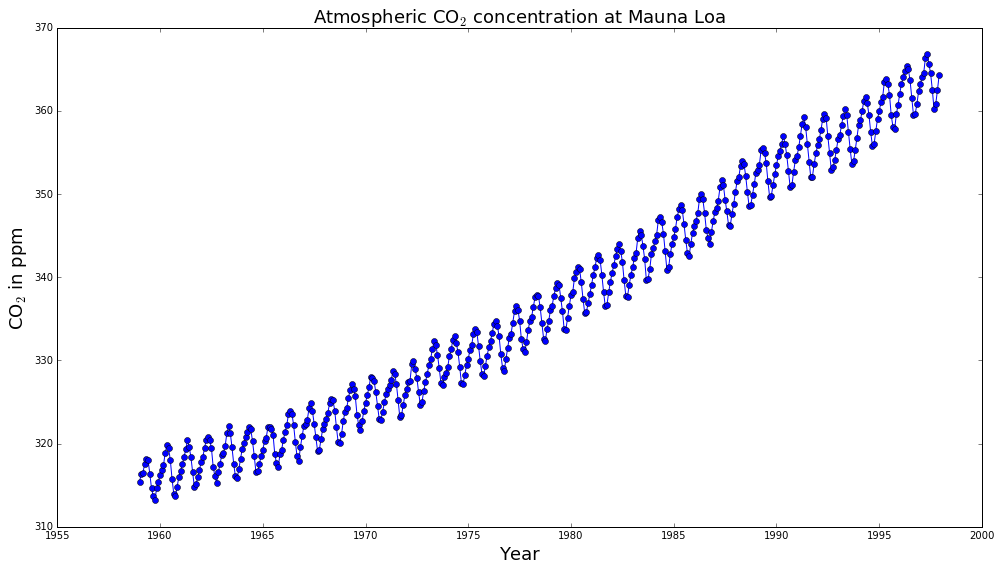

In [2]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.datasets import fetch_mldata

data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, [1]]
y = data[:, 0]
plt.plot(X,y,'o-')
plt.xlabel("Year", fontsize=18)
plt.ylabel(r"CO$_2$ in ppm", fontsize=18)
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa",fontsize=18)
plt.tight_layout()
plt.show()


Learned kernel: 34.5**2 * RBF(length_scale=41.8) + 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44, periodicity=1) + 0.446**2 * RationalQuadratic(alpha=17.6, length_scale=0.957) + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
Log-marginal-likelihood: -83.214


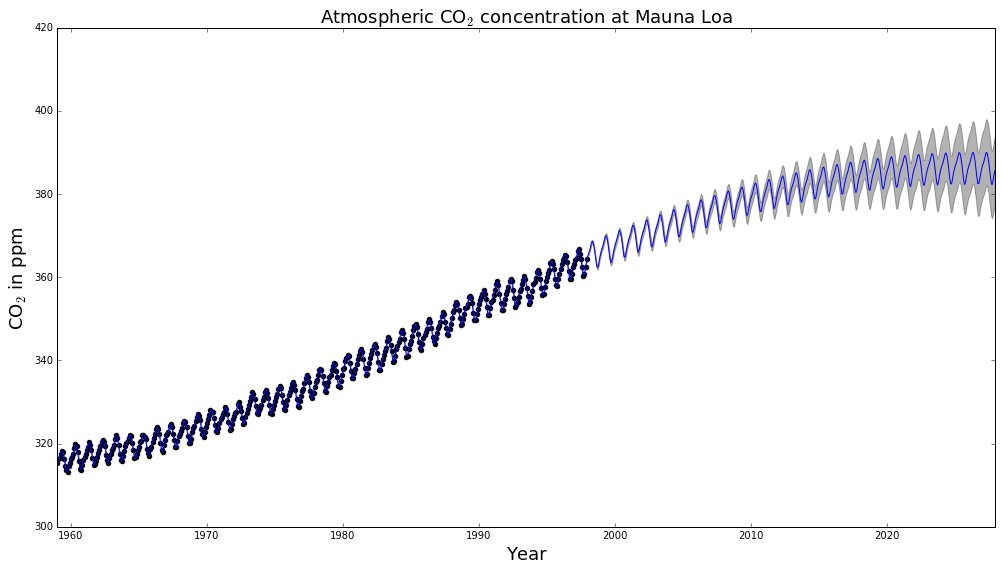

In [3]:
# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.3, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year", fontsize=18)
plt.ylabel(r"CO$_2$ in ppm", fontsize=18)
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa", fontsize=18)
plt.tight_layout()
plt.show()

Rémi: Note the dirty trick relying on local maxima for the RBF kernels